In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [74]:
balmer_line = pd.read_csv("HydrogenSeries.csv")
balmer_line_dataset = []
for i in range(1, 5):
    x = np.array([balmer_line['Run ' + str(i) + ': Wavelength (nm)'], balmer_line['Run ' + str(i) + ': Intensity (rel)']])
    balmer_line_dataset.append(x)

In [75]:
alpha_balmer_line = balmer_line_dataset[0]
beta_balmer_line = balmer_line_dataset[1]
gamma_balmer_line = balmer_line_dataset[2]
higher_balmer_line = balmer_line_dataset[3]

In [80]:
# function to optimize
def gaussian_peak(x, a, b, xp, sigma):
    return a + b*np.exp(-(((x-xp)**2)/(2*sigma*sigma)))

In [294]:
# input: balmer_line_dataset, wavelength mask
# output: least squared regression of waveform
# print-outs: avg peak-pos, fit values, plots of fit
def estimate_spectral_peak(b_line_dataset, lower_wave_bound, upper_wave_bound):
    wavelength_vals = b_line_dataset[0]
    intensity_vals = b_line_dataset[1]
    wav_val_masked = np.ma.masked_outside(wavelength_vals, lower_wave_bound, upper_wave_bound)
    int_val_masked = np.ma.masked_where(np.ma.getmask(wav_val_masked), intensity_vals)
    peak_pos_avg = (np.sum(wav_val_masked * int_val_masked))/(np.sum(int_val_masked))
    print('Average peak pos: ' + str(peak_pos_avg))
    popt, pcov = curve_fit(gaussian_peak, wav_val_masked, int_val_masked, p0=[0, 1, peak_pos_avg, (peak_pos_avg/100)])
    print('fit values: a: ' + str(popt[0]) + ' b: ' + str(popt[1]) + 
      ' xp: ' + str(popt[2]) + ' sigma: ' + str(popt[3]))
    plt.plot(wav_val_masked, int_val_masked, 'ko')
    plt.plot(wav_val_masked, gaussian_peak(wav_val_masked, *popt), 'b')
    plt.show()
    return popt[2]

# define array of estimated wavelengths
estimated_peak_wavelengths = np.zeros(shape=6)

Average peak pos: 655.7951502278884
fit values: a: 0.016893778868007418 b: 0.872413586474248 xp: 655.8460225499225 sigma: 0.3663363054646991


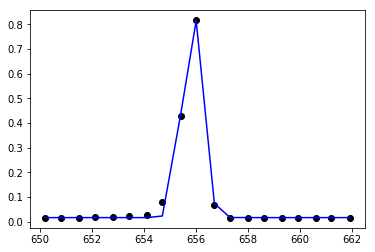

In [295]:
alpha_est = estimate_spectral_peak(alpha_balmer_line, 650., 662.)
estimated_peak_wavelengths[0] = alpha_est

Average peak pos: 485.5959755596059
fit values: a: 0.0248311216214811 b: 0.9370842771114797 xp: 485.600708984487 sigma: -0.4295153075109295


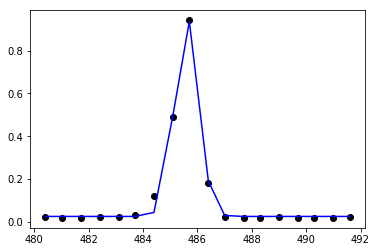

In [296]:
beta_est = estimate_spectral_peak(beta_balmer_line, 480., 492.)
estimated_peak_wavelengths[1] = beta_est

Average peak pos: 433.5027220392064
fit values: a: 0.11161786002540104 b: 1.014109803425753 xp: 433.1348105772214 sigma: 0.5544377017609408


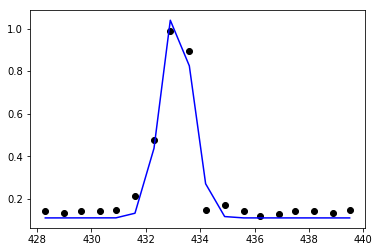

In [297]:
gamma_peak = estimate_spectral_peak(gamma_balmer_line, 428., 440.)
estimated_peak_wavelengths[2] = gamma_peak

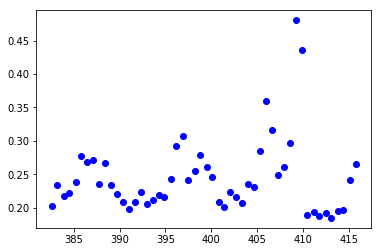

In [153]:
plt.plot(higher_balmer_line[0][np.logical_and(higher_balmer_line[0] >= 382., higher_balmer_line[0] <= 416.)], 
        higher_balmer_line[1][np.logical_and(higher_balmer_line[0] >= 382., higher_balmer_line[0] <= 416)], 
        'bo')
plt.show()

In [154]:
estimated_peak_wavelengths[3] = 409.2
estimated_peak_wavelengths[4] = 397.8
estimated_peak_wavelengths[5] = 386.9
print(estimated_peak_wavelengths)

[655.84602255 485.60070898 433.13481058 409.2        397.8
 386.9       ]


In [176]:
inv_wavelength_micron = 1e3 / estimated_peak_wavelengths
energy_level_no = np.arange(3, 9)

In [274]:
A = np.vstack([inv_wavelength_micron, np.ones(len(inv_wavelength_micron))]).T
energy_level_y = (1/4) - (1/(energy_level_no * energy_level_no))
m, b = np.linalg.lstsq(A, energy_level_y, rcond=None)[0]
print(m)
Rydberg_measured = 1/m
print("An estimate of the Rydberg constant: " + str(Rydberg_measured))

0.090727907254661
An estimate of the Rydberg constant: 11.021967002866438


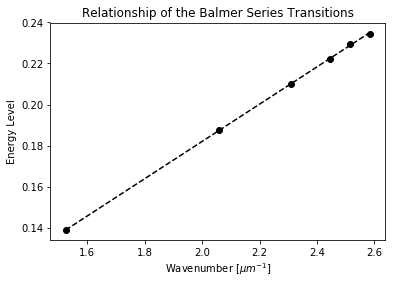

In [271]:
plt.plot(inv_wavelength_micron, energy_level_y, 'ko')
plt.plot(inv_wavelength_micron, ((m * inv_wavelength_micron) + b), 'k--')
plt.xlabel('Wavenumber ' + '[$\mu m^{-1}$]')
plt.ylabel('Energy Level')
plt.title('Relationship of the Balmer Series Transitions')
plt.show()

In [279]:
# calculation of Rydberg's constant using "reduced mass"
m_elec = 9.10938356e-31
m_prot = 1.672621898e-27
c = 299792458
e = 1.6021766208e-19
h = 6.626070040e-34
hbar = h/(2*np.pi)
mu_0 = 4*np.pi*1e-7
epsilon_0 = 1/(mu_0*(c**2))
m_reduced = (m_elec * m_prot)/(m_elec + m_prot)
Rydberg_reduced = ((1/(4*np.pi*epsilon_0)) * (1/(4*np.pi*epsilon_0))) * ((m_reduced * (e**4))/(4*np.pi*(hbar**3)*c))
Rydberg_reduced = Rydberg_reduced / 1e6

In [283]:
# Percent error of Rydberg
Rydberg_error = np.absolute((Rydberg_measured - Rydberg_reduced)/(Rydberg_reduced))
print('Percent Error of Rydberg Measurement: ' + str(Rydberg_error * 100) + '%')

Percent Error of Rydberg Measurement: 0.49425469181419435%


In [293]:
expected_values = Rydberg_reduced * energy_level_y
exp_wavelength = 1/expected_values
exp_wavelength = exp_wavelength * 1e3
diff_measured_wavelengths = exp_wavelength - estimated_peak_wavelengths
avg_difference = np.average(diff_measured_wavelengths)
print('Average deviation of the peak wavelengths: ' + str(avg_difference))

Average deviation of the peak wavelengths: 0.8118308495047112
